In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import scipy.stats as stats
import sklearn
import seaborn as sns

In [2]:
pd.plotting.register_matplotlib_converters()

In [3]:
Batman = pd.read_csv("Batman_Final.csv")
Batman['Date'] = pd.to_datetime(Batman['Date'], format="%Y/%m")
Batman.head()

,File,Date,Rank,Comic-book_Title,Issue,Price,Publisher,Units_Sold,Writer,Rating,Movie_Playing
0,1997-04.csv,1997-04-01,46,Batman,543,1.95,DC,59706,Doug Moench,NaN,0
1,1997-04.csv,1997-04-01,48,Detective Comics,710,1.95,DC,55389,Chuck Dixon,NaN,0
2,1997-05.csv,1997-05-01,31,Batman,544,1.95,DC,58451,Doug Moench,NaN,0
3,1997-06.csv,1997-06-01,33,Batman,545,1.95,DC,57641,Doug Moench,NaN,1
4,1997-06.csv,1997-06-01,35,Detective Comics,712,1.95,DC,53416,Chuck Dixon,NaN,1


In [4]:
Batman.describe

<bound method NDFrame.describe of             File       Date  Rank  Comic-book_Title  Issue  Price Publisher  \
0    1997-04.csv 1997-04-01    46            Batman    543   1.95        DC   
1    1997-04.csv 1997-04-01    48  Detective Comics    710   1.95        DC   
2    1997-05.csv 1997-05-01    31            Batman    544   1.95        DC   
3    1997-06.csv 1997-06-01    33            Batman    545   1.95        DC   
4    1997-06.csv 1997-06-01    35  Detective Comics    712   1.95        DC   
..           ...        ...   ...               ...    ...    ...       ...   
613  2019-11.csv 2019-11-01    31  Detective Comics   1015   3.99        DC   
614  2019-11.csv 2019-11-01    47  Detective Comics   1016   3.99        DC   
615  2019-12.csv 2019-12-01    12            Batman     85   4.99        DC   
616  2019-12.csv 2019-12-01    15            Batman     84   3.99        DC   
617  2019-12.csv 2019-12-01    49  Detective Comics   1017   3.99        DC   

     Units_Sold  

In [5]:
Batman.dtypes

File                        object
Date                datetime64[ns]
Rank                         int64
Comic-book_Title            object
Issue                        int64
Price                      float64
Publisher                   object
Units_Sold                   int64
Writer                      object
Rating                     float64
Movie_Playing                int64
dtype: object

In [6]:
Batman['Movie_Playing'].value_counts()

0    551
1     67
Name: Movie_Playing, dtype: int64

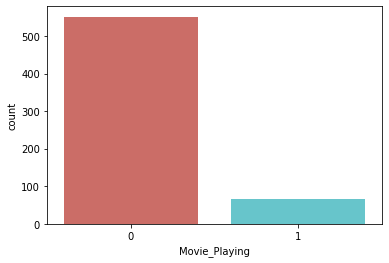

In [7]:
sns.countplot(x='Movie_Playing', data=Batman, palette='hls')
plt.show()

In [8]:
count_no_movie = len(Batman[Batman['Movie_Playing']==0])
count_movie = len(Batman[Batman['Movie_Playing']==1])
pct_of_no_movie = count_no_movie/(count_no_movie+count_movie)
print("percentage of no movie is", pct_of_no_movie*100)
pct_of_movie = count_movie/(count_no_movie+count_movie)
print("percentage of movie", pct_of_movie*100)

percentage of no movie is 89.15857605177993
percentage of movie 10.841423948220065


In [9]:
Batman.groupby('Movie_Playing').mean()

,Rank,Issue,Price,Units_Sold,Rating
Movie_Playing,,,,,
0,20.655172,4163.431942,3.110599,72955.348457,7.986111
1,22.791045,556.044776,3.174179,71916.850746,7.708696


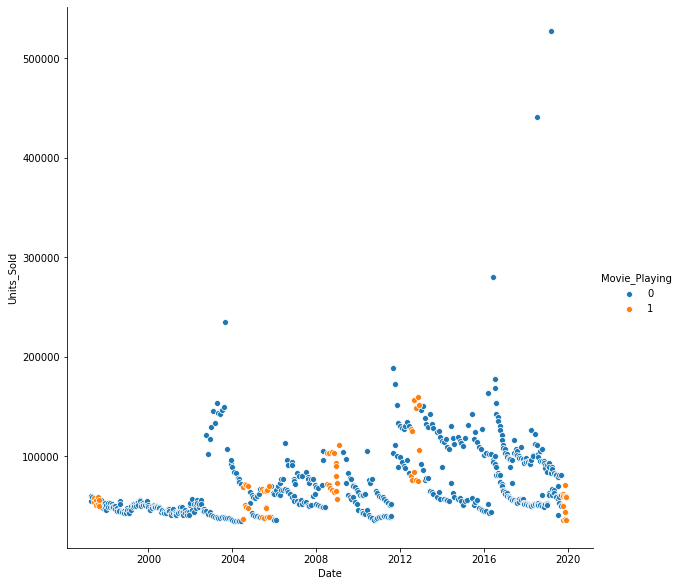

In [10]:
sns.pairplot(x_vars=["Date"], y_vars=["Units_Sold"], data=Batman, hue="Movie_Playing", height = 8)
plt.show()

In [11]:
# Bayesian

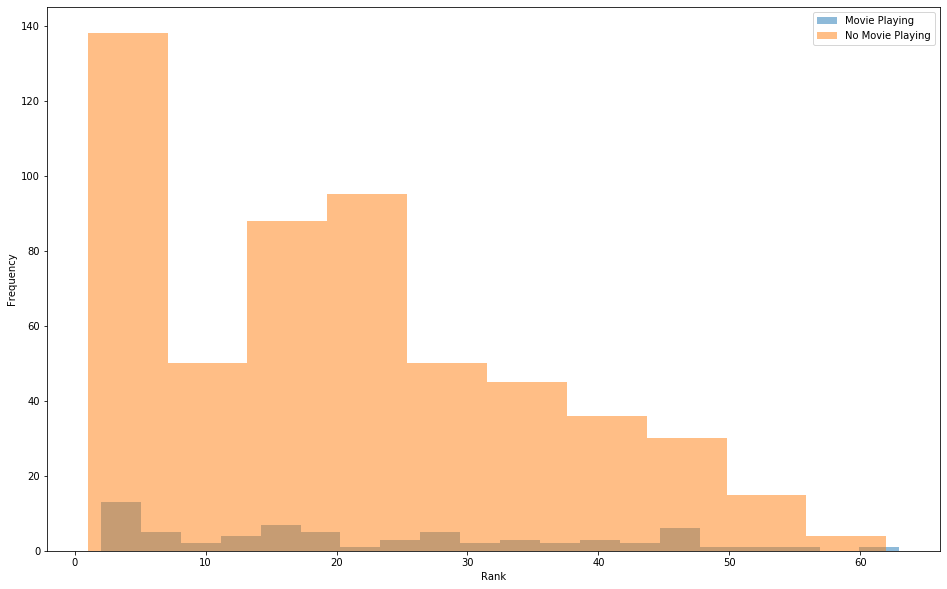

In [12]:
movie_bay = Batman.Rank[Batman.Movie_Playing == 1]
no_movie_bay = Batman.Rank[Batman.Movie_Playing == 0]
n_mov = len(movie_bay)
n_no_mov = len(no_movie_bay)
plt.figure(figsize=(16,10))
plt.hist(movie_bay, bins=20, alpha=0.5, label='Movie Playing')
plt.hist(no_movie_bay, bins=10, alpha=0.5, label='No Movie Playing')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()

In [13]:
alpha_est = np.mean(movie_bay)**2 / np.var(movie_bay)
beta_est = np.var(movie_bay) / np.mean(movie_bay)
alpha_est, beta_est

(1.966757762089121, 11.58813007653286)

In [14]:
from numpy.random import seed
from scipy.stats import gamma
seed(47)
movie_model_rvs = gamma(alpha_est, scale=beta_est).rvs(n_mov)

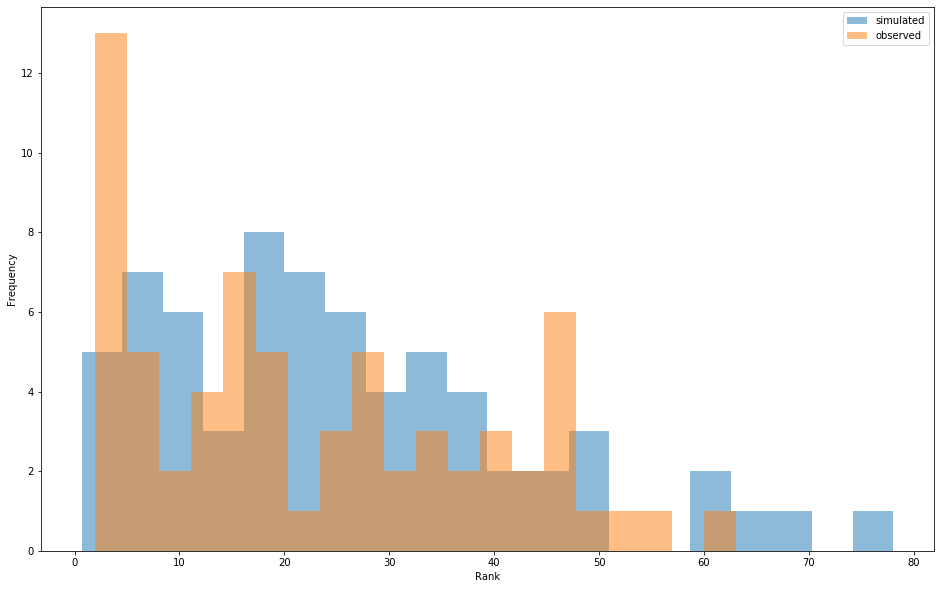

In [15]:
plt.figure(figsize=(16,10))
plt.hist(movie_model_rvs, bins=20, alpha=0.5, label='simulated')
plt.hist(movie_bay, bins=20, alpha=0.5, label='observed')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()

In [16]:
rate_est = 1/beta_est
alpha_est, rate_est

(1.966757762089121, 0.08629519977732228)

In [17]:
import pymc3 as pm
with pm.Model() as movie_model:
    alpha_ = pm.Exponential("alpha", 1/alpha_est)   
    rate_ = pm.Exponential("beta", 1/rate_est)
    gamma_distribution = pm.Gamma("movie", alpha=alpha_, beta=rate_, observed=movie_bay)
    trace = pm.sample(2000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1463.00draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [18]:
alpha_trace = trace["alpha"]
#95% interval
alpha_interval = np.percentile(alpha_trace, [2.5,97.5])
alpha_interval

array([1.06544999, 2.04302501])

In [19]:
beta_trace = trace["beta"]
#95% interval
beta_interval = np.percentile(beta_trace, [2.5,97.5])
beta_interval

array([0.04379786, 0.09404507])

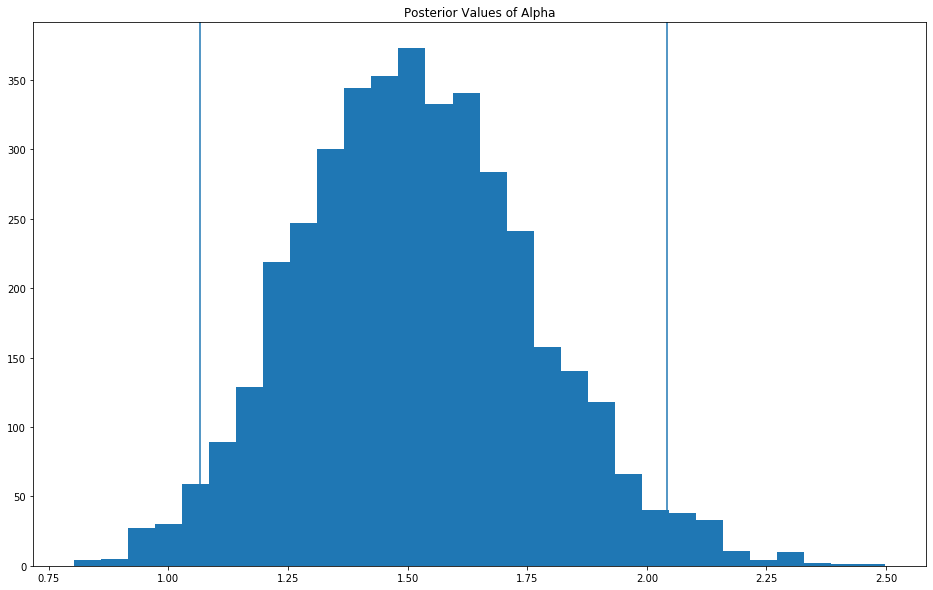

In [20]:
plt.figure(figsize=(16,10))
plt.title("Posterior Values of Alpha")
plt.hist(alpha_trace, bins=30)
plt.axvline(x=alpha_interval[0])
plt.axvline(x=alpha_interval[1])
plt.show()

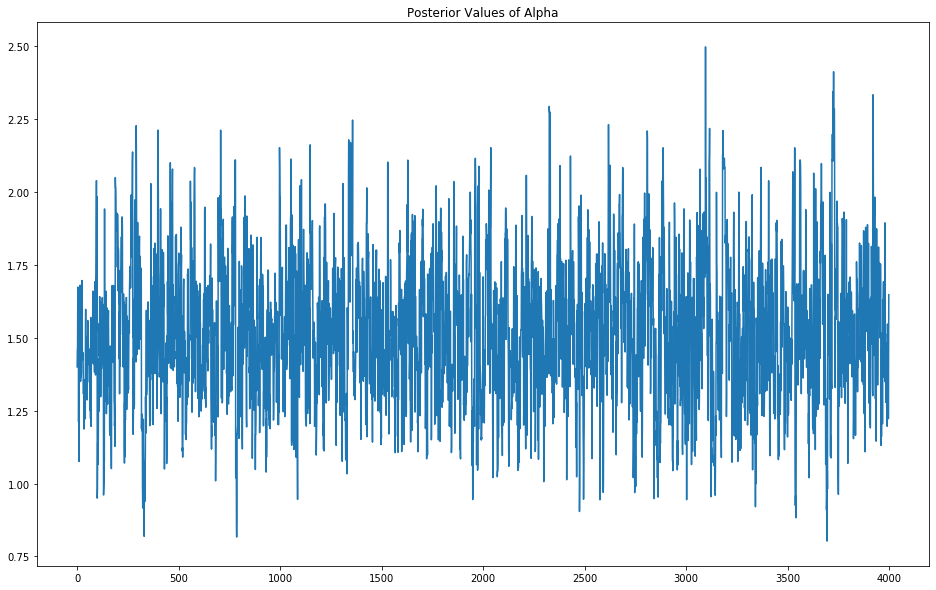

In [21]:
plt.figure(figsize=(16,10))
plt.title("Posterior Values of Alpha")
plt.plot(alpha_trace)
plt.show()

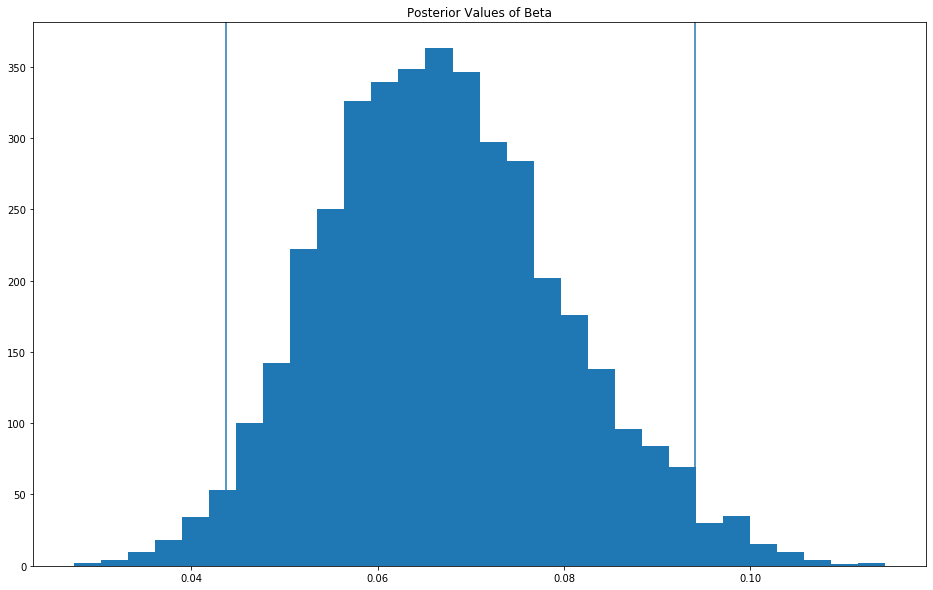

In [22]:
plt.figure(figsize=(16,10))
plt.title("Posterior Values of Beta")
plt.hist(beta_trace, bins=30)
plt.axvline(x=beta_interval[0])
plt.axvline(x=beta_interval[1])
plt.show()

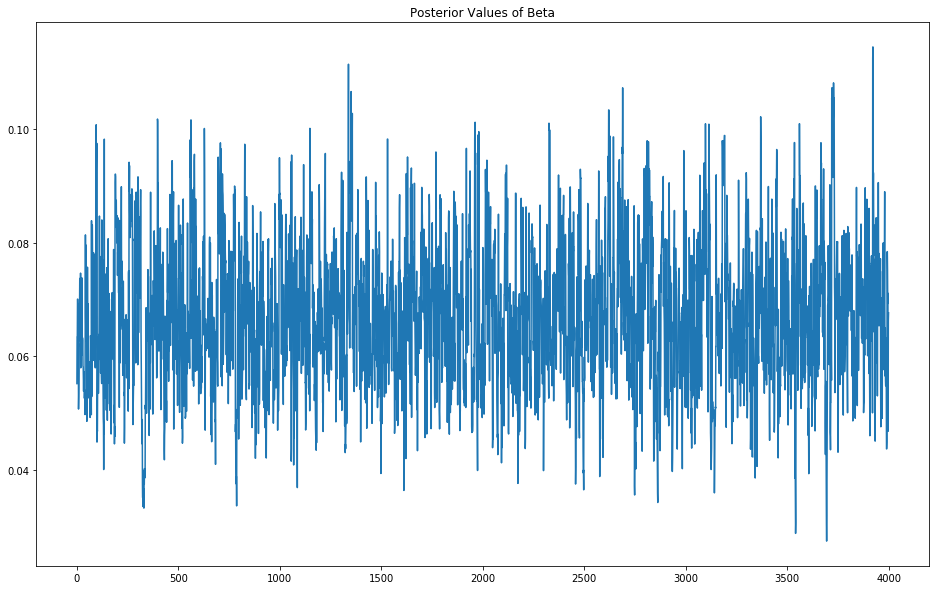

In [23]:
plt.figure(figsize=(16,10))
plt.title("Posterior Values of Beta")
plt.plot(beta_trace)
plt.show()

In [24]:
alpha_final = np.mean(alpha_trace)
beta_final = np.mean(beta_trace)
seed(47)
final_simulation = gamma(alpha_final, scale=1/beta_final).rvs(n_mov)

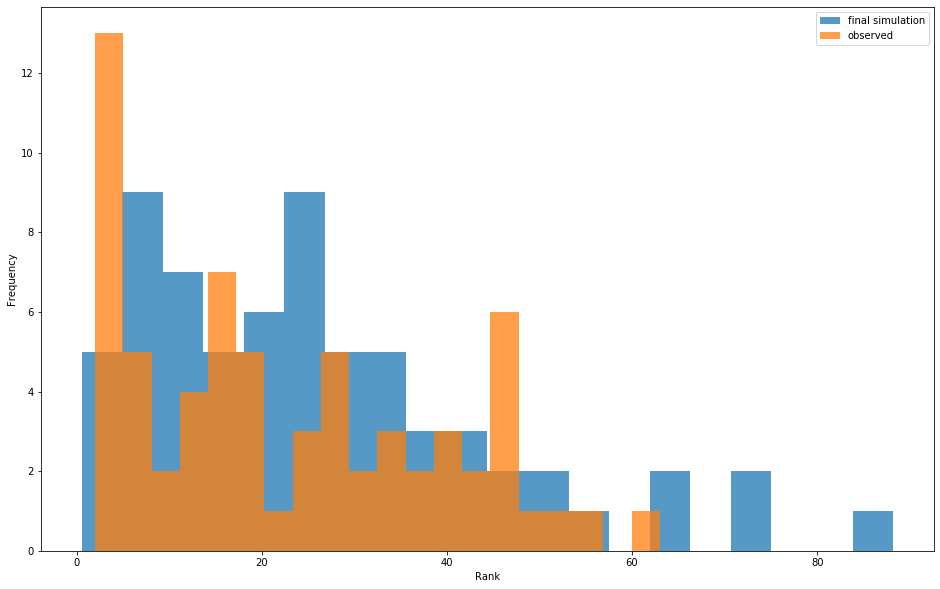

In [25]:
plt.figure(figsize=(16,10))
plt.hist(final_simulation, bins=20, alpha = 0.75, label='final simulation')
plt.hist(movie_bay, bins=20, alpha = 0.75, label='observed')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [26]:
# Frequentist

<function matplotlib.pyplot.show(*args, **kw)>

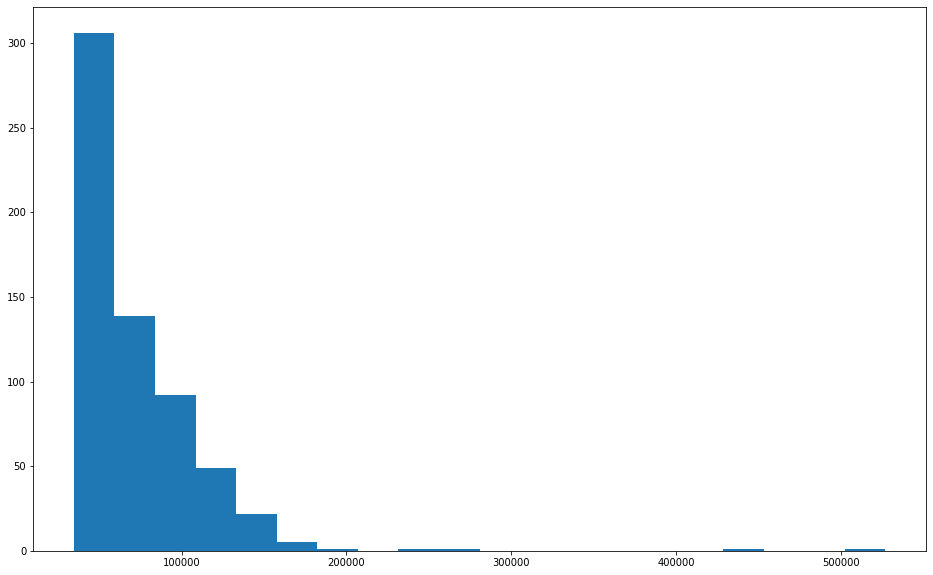

In [27]:
plt.figure(figsize=(16,10))
plt.hist(Batman.Units_Sold, bins=20)
plt.show

In [28]:
sold_mean = np.mean(Batman.Units_Sold)
sold_std = np.std(Batman.Units_Sold, ddof=1)
(sold_mean, sold_std)

(72842.76051779935, 39477.061852095314)

In [29]:
Batman.Units_Sold.median()

59568.5

In [30]:
from scipy.stats import t
critical_value = t.ppf(.95, len(Batman.Units_Sold))
critical_value

1.6473229955377264

In [31]:
standard_error = sold_std/np.sqrt(len(Batman.Units_Sold))
margin_error = critical_value*standard_error
margin_error

2615.949437668909

In [32]:
confidence_interval = [sold_mean - margin_error, sold_mean + margin_error]
confidence_interval

[70226.81108013044, 75458.70995546826]

In [33]:
stats.ttest_ind(Batman.Units_Sold[Batman.Movie_Playing == 1], Batman.Units_Sold[Batman.Movie_Playing == 0], equal_var = False)

Ttest_indResult(statistic=-0.2587682108369141, pvalue=0.7963525565122721)

In [34]:
# Bootstrap

In [35]:
np.random.seed(47)
N_rep = 10000
def bootstrap(data, func, N_rep):
    bootstrap_rep = np.empty(N_rep)
    for i in range(N_rep):
        bootstrap_sample = np.random.choice(data, len(data))
        bootstrap_rep[i] = func(bootstrap_sample)
    return bootstrap_rep
bootstrap_mean = bootstrap(Batman.Units_Sold, np.mean, 10000)
lower_limit = np.percentile(bootstrap_mean, 5)
lower_limit

70360.02653721682

In [36]:
movie_boot = np.array(Batman[Batman['Movie_Playing']==1].Units_Sold)
no_movie_boot = np.array(Batman[Batman['Movie_Playing']==0].Units_Sold)
difference_std = np.std(movie_boot) - np.std(no_movie_boot)
difference_std

-11060.784399124062

In [37]:
bootstrap_std = bootstrap(no_movie_boot, np.std, N_rep) - bootstrap(movie_boot, np.std, N_rep)
conf_interval = np.percentile(bootstrap_std,[2.5, 97.5])
conf_interval

array([-1084.69786782, 24057.82928731])

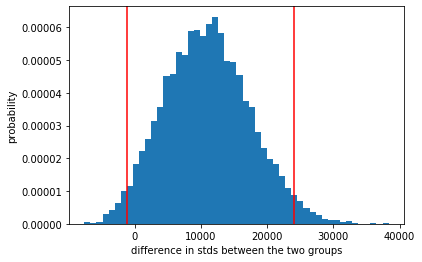

In [38]:
plt.hist(bootstrap_std, bins=50, density=True)
plt.axvline(conf_interval[0], color='red')
plt.axvline(conf_interval[1], color='red')
plt.xlabel('difference in stds between the two groups')
plt.ylabel('probability')
plt.show()

In [39]:
combined_mean = np.mean(np.concatenate((movie_boot, no_movie_boot)))
movie_adjusted = movie_boot - np.mean(movie_boot) + combined_mean
no_movie_adjusted = no_movie_boot - np.mean(no_movie_boot) + combined_mean

In [40]:
bootstrap_movie_adjusted = bootstrap(movie_adjusted, np.mean, N_rep)
bootstrap_no_movie_adjusted = bootstrap(no_movie_adjusted, np.mean, N_rep)

In [41]:
bootstrap_differences = bootstrap_movie_adjusted - bootstrap_no_movie_adjusted
data_difference = np.mean(movie_boot) - np.mean(no_movie_boot)
data_difference

-1038.4977110816253

In [42]:
p_value = np.sum(bootstrap_differences >= data_difference)/ len(bootstrap_differences)
p_value

0.5966

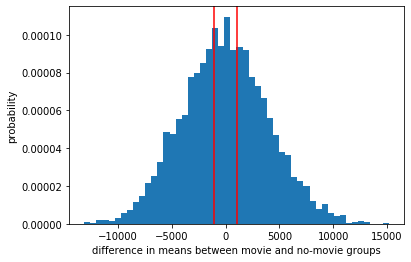

In [43]:
plt.hist(bootstrap_differences, bins=50, density=True)
plt.xlabel("difference in means between movie and no-movie groups")
plt.ylabel("probability")
plt.axvline(data_difference, color='r')
plt.axvline(-data_difference, color='r')
plt.show()

In [44]:
# Logistic Regression

In [45]:
Batman['Date'] = pd.to_numeric(Batman['Date'])

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Batman[['Date','Units_Sold']].values, 
                                              (Batman.Movie_Playing == "1").values,random_state=5)
clf = LogisticRegression()
clf.fit(Xlr, ylr)
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

E:\Anaconda\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False